## Airline Arrivals Supervised learning potpourri

In [98]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn import ensemble

## Dataset

This dataset is lcoated here http://stat-computing.org/dataexpo/2009/the-data.html, the data itself is from RITA and includes data from several airlines, different reasons for delays, cancellations, departure and arrival times, and the day, month and year the flight happened. For the taxi-in and taxi-out features, I did not know what that was, so I had to look it up. Taxi-out is the time it takes the plane to get in the sky after it starts moving. Taxi-in is how long it takes to get to the drop off point once it reaches the destination airport.

In [2]:
airline_df = pd.read_csv('2008.csv')

My desire for this project is to make a model that predicts flights will be late. For this project, flights will only be considered late after being 30 minutes late or more. My goal is to predict whether a flight will be late based on the data provided.

## Explore

In [3]:
airline_df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [4]:
airline_df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

There is a lot of NaNs results for the different delays that can occur, if I just remove NaNs I could be skewing the dataset to a less accurate result. TI will need to look into these features to decide on what I what to do about the NaNs.

In [5]:
airline_df.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,7009728.0,7.009728e+06,7.009728e+06,7.009728e+06,6.873482e+06,7.009728e+06,6.858079e+06,7.009728e+06,7.009728e+06,6.855029e+06,...,7.009728e+06,6.858079e+06,6.872670e+06,7.009728e+06,7.009728e+06,1.524735e+06,1.524735e+06,1.524735e+06,1.524735e+06,1.524735e+06
mean,2008.0,6.375130e+00,1.572801e+01,3.924182e+00,1.333830e+03,1.326086e+03,1.481258e+03,1.494801e+03,2.224200e+03,1.273224e+02,...,7.263870e+02,6.860852e+00,1.645305e+01,1.960618e-02,2.463006e-03,1.577206e+01,3.039031e+00,1.716462e+01,7.497434e-02,2.077098e+01
std,0.0,3.406737e+00,8.797068e+00,1.988259e+00,4.780689e+02,4.642509e+02,5.052251e+02,4.826728e+02,1.961716e+03,7.018731e+01,...,5.621018e+02,4.933649e+00,1.133280e+01,1.386426e-01,4.956753e-02,4.009912e+01,1.950287e+01,3.189495e+01,1.837940e+00,3.925964e+01
min,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,9.280000e+02,9.250000e+02,1.107000e+03,1.115000e+03,6.220000e+02,7.700000e+01,...,3.250000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.320000e+03,1.512000e+03,1.517000e+03,1.571000e+03,1.100000e+02,...,5.810000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
75%,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.728000e+03,1.715000e+03,1.909000e+03,1.907000e+03,3.518000e+03,1.570000e+02,...,9.540000e+02,8.000000e+00,1.900000e+01,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,2.100000e+01,0.000000e+00,2.600000e+01
max,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.743000e+03,1.379000e+03,...,4.962000e+03,3.080000e+02,4.290000e+02,1.000000e+00,1.000000e+00,2.436000e+03,1.352000e+03,1.357000e+03,3.920000e+02,1.316000e+03


In [6]:
# This shows all the NaNs among my features
null_count = airline_df.isnull().sum()
null_count[null_count>0]

DepTime               136246
ArrTime               151649
TailNum                83365
ActualElapsedTime     154699
CRSElapsedTime           844
AirTime               154699
ArrDelay              154699
DepDelay              136246
TaxiIn                151649
TaxiOut               137058
CancellationCode     6872294
CarrierDelay         5484993
WeatherDelay         5484993
NASDelay             5484993
SecurityDelay        5484993
LateAircraftDelay    5484993
dtype: int64

Some of these features have an extreme number of NaNs. Good thing is the features that have that problem, I believe likely did not have a delay, so I could replace them with 0s for 0 minutes.

In [7]:
#removing the NANs from several of the features that did not have a vast majority of NANs
new_df = airline_df[np.isfinite(airline_df['DepTime'])]
new_df = new_df[np.isfinite(new_df['ArrTime'])]
new_df = new_df[np.isfinite(new_df['ActualElapsedTime'])]
new_df = new_df[np.isfinite(new_df['CRSElapsedTime'])]
new_df = new_df[np.isfinite(new_df['ArrDelay'])]
new_df = new_df[np.isfinite(new_df['DepDelay'])]
new_df = new_df[np.isfinite(new_df['TaxiIn'])]
new_df = new_df[np.isfinite(new_df['TaxiOut'])]

In [12]:
# I chose to replace the NaN for the delay times with zero because I believe this is what most, if not all those numbers are.  
air_df = new_df.fillna(0)

In [13]:
# I want to create a new feature that shows whether the flight was late or not
air_df['late'] = air_df['ArrDelay'] > 30

In [16]:
# False is flights that were on time and True is flights that were late
air_df['late'].value_counts()

False    5953631
True      901398
Name: late, dtype: int64

In [18]:
# percentage of planes that were late in 2008 according to the data
901398/7009728

0.1285924361116437

I am actually surprised it was that that high, nearly 13% of the flights were late that year.

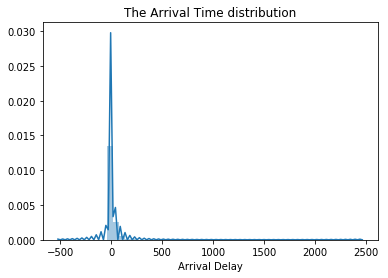

In [19]:
sns.distplot(air_df['ArrDelay'])
plt.title('The Arrival Time distribution')
plt.xlabel('Arrival Delay')
plt.show()

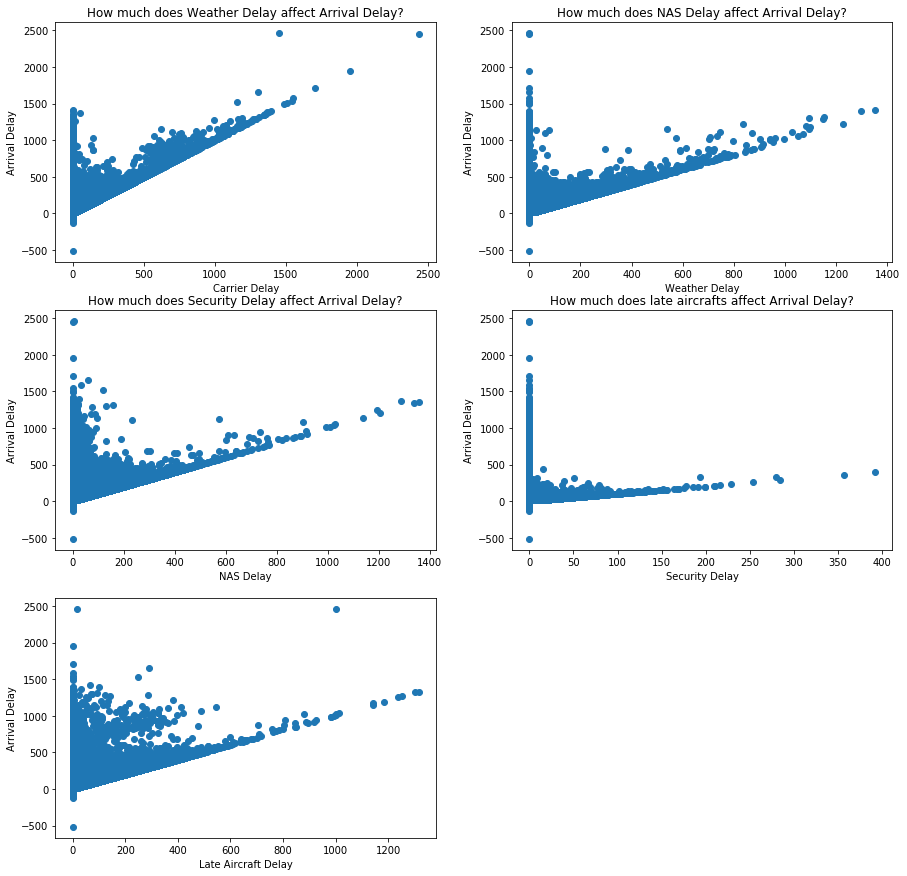

In [20]:
# This should show a relationship between the delays and how late it makes the flights, I want to see if any of the features stand out
plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.title('How much does Carrier Delay affect Arrival Delay?')
plt.scatter(air_df['CarrierDelay'], air_df['ArrDelay'])
plt.xlabel('Carrier Delay')
plt.ylabel('Arrival Delay')

plt.title('How much does Weather Delay affect Arrival Delay?')
plt.subplot(3, 2, 2)
plt.scatter(air_df['WeatherDelay'], air_df['ArrDelay'])
plt.xlabel('Weather Delay')
plt.ylabel('Arrival Delay')

plt.title('How much does NAS Delay affect Arrival Delay?')
plt.subplot(3, 2, 3)
plt.scatter(air_df['NASDelay'], air_df['ArrDelay'])
plt.xlabel('NAS Delay')
plt.ylabel('Arrival Delay')

plt.title('How much does Security Delay affect Arrival Delay?')
plt.subplot(3, 2, 4)
plt.scatter(air_df['SecurityDelay'], air_df['ArrDelay'])
plt.xlabel('Security Delay')
plt.ylabel('Arrival Delay')

plt.title('How much does late aircrafts affect Arrival Delay?')
plt.subplot(3, 2, 5)
plt.scatter(air_df['LateAircraftDelay'], air_df['ArrDelay'])
plt.xlabel('Late Aircraft Delay')
plt.ylabel('Arrival Delay')
plt.show()

## Tuning the model

In [55]:
X = air_df.drop(['ArrDelay', 'late', 'FlightNum', 'CancellationCode', 'Cancelled', 'Diverted', 'Origin', 'TailNum'], 1)
y = air_df['late']

In [61]:
model = BernoulliNB()

# Train the model using the training sets 
cross_val_score(model, X, y, cv=5)

array([ 0.90818792,  0.9157283 ,  0.91706163,  0.92185003,  0.92295652])

In [66]:
# Getting a ranking of the features
selectr = RFE(model)
selector = selectr.fit(X, y)
rankings = pd.DataFrame({'Features': X.columns, 'Ranking' : selector.ranking_})
rankings.sort_values('Ranking')

,Features,Ranking
9,CRSElapsedTime,1
17,NASDelay,1
16,WeatherDelay,1
15,CarrierDelay,1
14,TaxiOut,1
13,TaxiIn,1
11,DepDelay,1
10,AirTime,1
18,SecurityDelay,1
19,LateAircraftDelay,1


In [71]:
X = air_df.drop(['ArrDelay', 'late', 'FlightNum', 'CancellationCode', 'Cancelled', 'Diverted', 'Origin', 'TailNum', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime', 'ActualElapsedTime', 'Distance', 'CRSArrTime', 'Origin', 'Dest', 'UniqueCarrier'], 1)
cross_val_score(model, X, y, cv=5)

array([ 0.90818792,  0.9157283 ,  0.91706163,  0.92185003,  0.92295652])

In [94]:
bnb0 = BernoulliNB(alpha = 0)
cross_val_score(bnb0, X, y, cv=5)

C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:838: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:841: RuntimeWarning: invalid value encountered in add
  jll += self.class_log_prior_ + neg_prob.sum(axis=1)
C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:838: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\naive_bay

array([ 0.86850541,  0.86850532,  0.86850532,  0.86850595,  0.86850595])

## Random Forest

In [99]:
# I initially did this just to see how close it was to my naive bayes model. Normally I would want to tune random forest to get the best numbers
# but a downside to random forest is it is processor intensive and this model is massive. I actually thought my program crashes again, but
# after a taking a break it resolved. Tuning this model would probably have taken hours or longer for each attribute. 
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, y, cv=5)

array([ 0.9996353 ,  0.99955288,  0.99967032,  0.99959956,  0.99949161])

## Conclusion

The important features should not have been very surprising, knowing the delays gave the model better information than the other features such as carriers, location and distance. Using this model I can make an accurate prediction with my random forest model(very near 100%) on whether a flight is going to be late if I have data on the delays. While my Naive Bayes was quite accurate my random forest model was extremely accurate and I left the tuning at defaults.